# Assignment 2 -- ML4F 2021

## Instructions

* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment2_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment2_group03.ipynb`.
* The notebook should run without raising any errors. 
* We recommend keeping the folder structure
```
assignment/
    data/
    lib/
    assignment2_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `L2-git-slides.pdf`.
* Do not spend time on optimizing the speed of your code. 
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize
from scipy.stats import mstats
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
# from sklearn.metrics import classification_report
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from sklearn.manifold import TSNE
from sklearn import tree

In [2]:
import yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

## Introduction

The Paycheck Protection Program (PPP) gives support to companies who are negatively impacted by Covid-19 to pay their employees. Many businesses have been affected and the money was limited. This means the PPP cannot give all the companies money. The dataset provided contains the loans to different companies. It also contains the probability of default (`ProbabilityDefault`) as estimated by the loan officer.

Let's load and have a look at the data.

In [3]:
path = os.path.join('data','loans.xlsx')

df_data = pd.read_excel(path)
df_data.head(10)

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
0,20800,EAGLE,ID,83616,531210.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,2020-07-04 00:00:00,Washington Trust Bank,ID - 01,117,1.250967
1,80000,HAYDEN,ID,83835,722511.0,Corporation,Asian,Female Owned,Unanswered,NaN,24.0,04/15/2020,Glacier Bank,ID - 01,230,6.033691
2,75500,IDAHO FALLS,ID,83401,811121.0,Subchapter S Corporation,White,Male Owned,Non-Veteran,NaN,7.0,2020-10-04 00:00:00,Bank of Idaho,ID - 02,236,2.334621
3,133500,POST FALLS,ID,83854,722211.0,Limited Liability Company(LLC),White,Unanswered,Unanswered,NaN,26.0,04/13/2020,First Interstate Bank,ID - 01,240,9.567953
4,8187,RIGBY,ID,83442,327991.0,Sole Proprietorship,White,Male Owned,Non-Veteran,NaN,1.0,2020-05-05 00:00:00,Beehive FCU,ID - 02,51,1.462785
5,16700,MERIDIAN,ID,83642,621330.0,Limited Liability Company(LLC),Unanswered,Female Owned,Non-Veteran,NaN,0.0,04/28/2020,Idaho Central CU,ID - 01,121,8.855862
6,26900,MOSCOW,ID,83843,621310.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,2.0,2020-08-06 00:00:00,"Zions Bank, A Division of",ID - 01,144,3.322314
7,40600,IDAHO FALLS,ID,83402,722513.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,04/28/2020,Idaho Central CU,ID - 02,182,4.111426
8,58767,LEWISTON,ID,83501,811111.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,4.0,2020-03-05 00:00:00,"U.S. Bank, National Association",ID - 01,211,5.022466
9,46000,BOISE,ID,83706,524210.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,4.0,2020-12-04 00:00:00,KeyBank National Association,ID - 02,199,4.404192


# Question 1
(12 points)

Use the methods discussed so far to preprocess the data. Make some descriptive statistics and histograms etc to find out more about the distributions of the data. Are there NaNs, outliers etc? Then choose what preprocessing to apply and clearly explain your choices.

In [4]:
df_data.dtypes

LoanAmount             object
City                   object
State                  object
Zip                     int64
NAICSCode             float64
BusinessType           object
RaceEthnicity          object
Gender                 object
Veteran                object
NonProfit              object
JobsRetained          float64
DateApproved           object
Lender                 object
CD                     object
AgeLoan                 int64
ProbabilityDefault    float64
dtype: object

In [5]:
df_data['LoanAmount'] = pd.to_numeric(df_data['LoanAmount'],errors='coerce')

array([[<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Zip'}>],
       [<AxesSubplot:title={'center':'NAICSCode'}>,
        <AxesSubplot:title={'center':'JobsRetained'}>],
       [<AxesSubplot:title={'center':'AgeLoan'}>,
        <AxesSubplot:title={'center':'ProbabilityDefault'}>]],
      dtype=object)

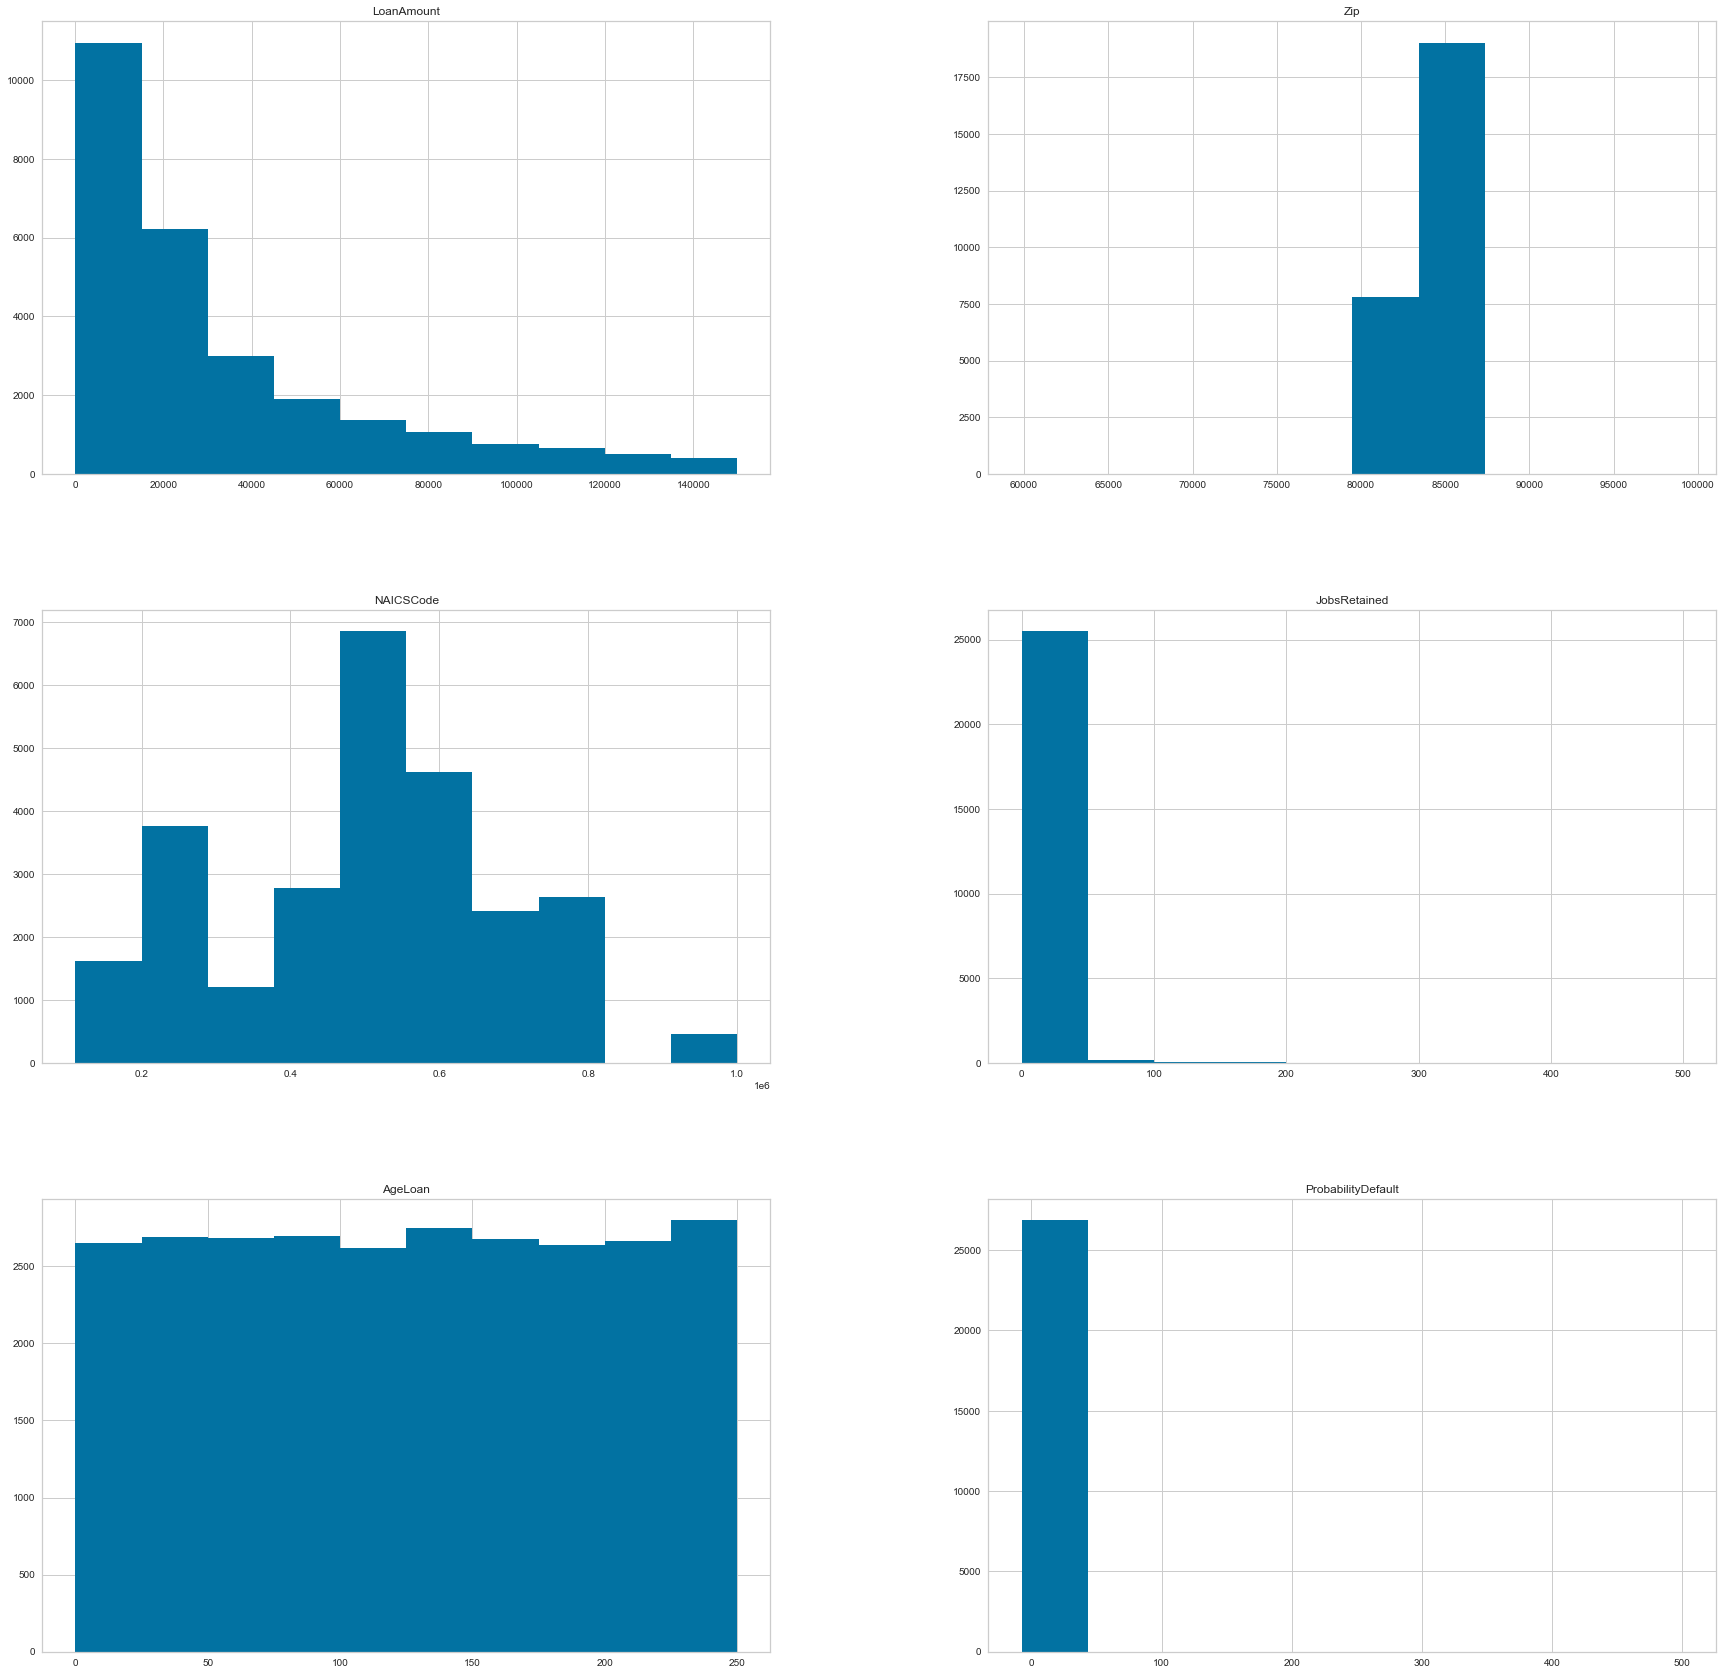

In [6]:
df_data.hist(figsize=(30,30))

In [7]:
stats = pd.DataFrame(df_data.describe(include='all'))
stats

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
count,26852.000000,26855,26855,26855.000000,26333.000000,26838,26855,26855,26855,517,25780.000000,26855,26855,26855,26855.000000,26855.000000
unique,NaN,352,1,NaN,NaN,15,6,3,3,1,NaN,77,289,4,NaN,NaN
top,NaN,BOISE,ID,NaN,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,Y,NaN,04/28/2020,Idaho Central CU,ID - 01,NaN,NaN
freq,NaN,4949,26855,NaN,NaN,11049,24308,21450,22872,517,NaN,3577,3617,14370,NaN,NaN
mean,32639.463601,NaN,NaN,83573.683076,510319.572400,NaN,NaN,NaN,NaN,NaN,5.651862,NaN,NaN,NaN,124.983132,3.244025
std,33270.802106,NaN,NaN,309.367113,203553.540773,NaN,NaN,NaN,NaN,NaN,15.293767,NaN,NaN,NaN,72.430690,3.821607
min,52.000000,NaN,NaN,59847.000000,111110.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,-7.566606
25%,8847.500000,NaN,NaN,83402.000000,423110.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,62.000000,1.558186
50%,20143.210000,NaN,NaN,83642.000000,532412.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,125.000000,2.732590
75%,44800.000000,NaN,NaN,83706.000000,621399.000000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,188.000000,4.342069


In [8]:
df_data.isna().sum()

LoanAmount                3
City                      0
State                     0
Zip                       0
NAICSCode               522
BusinessType             17
RaceEthnicity             0
Gender                    0
Veteran                   0
NonProfit             26338
JobsRetained           1075
DateApproved              0
Lender                    0
CD                        0
AgeLoan                   0
ProbabilityDefault        0
dtype: int64

In [9]:
##We can maybe drop outliers in this section, because we only drop 17 rows not too much right?
df_data.BusinessType.unique() 

array(['Limited  Liability Company(LLC)', 'Corporation',
       'Subchapter S Corporation', 'Sole Proprietorship',
       'Limited Liability Partnership', 'Independent Contractors',
       'Partnership', 'Self-Employed Individuals',
       'Non-Profit Organization', 'Professional Association', nan,
       'Cooperative', 'Joint Venture', 'Non-Profit Childcare Center',
       'Tenant in Common', 'Trust'], dtype=object)

In [10]:
df_data.JobsRetained.unique()
##Put the median/mean here to the nan values

array([  0.,  24.,   7.,  26.,   1.,   2.,   4.,  10.,  nan,   3.,  25.,
        17.,  11.,  14.,   8.,  12.,  20.,  13.,   9.,   5.,  19.,  18.,
         6.,  27.,  15.,  60.,  22., 250.,  16., 120.,  39.,  30.,  35.,
        52.,  34.,  31.,  40.,  57.,  48.,  23.,  61.,  29.,  21., 100.,
        28.,  90.,  72., 112.,  50., 280.,  41.,  70.,  45.,  97.,  32.,
        53.,  55.,  43., 109., 130.,  33.,  74.,  46.,  80.,  67.,  44.,
        37., 170., 160., 200.,  42.,  66., 420.,  36.,  47.,  62., 180.,
        84., 110.,  65., 320.,  38., 400.,  56., 132.,  69., 500.,  49.,
       300., 150., 380.,  54.,  85., 315., 202.,  83., 225.,  75., 154.,
        51., 152., 410.,  92.,  58., 140.,  82., 350., 236., 220., 107.])

In [11]:
#Make dummies --> or fill nans with no or filling it with one for yes and 0 for no.
df_data.NonProfit.unique()

array([nan, 'Y'], dtype=object)

In [12]:
df_data.NAICSCode.unique()
#Making new variable --> where nans are industries that are not defined

array([531210., 722511., 811121., 722211., 327991., 621330., 621310.,
       722513., 811111., 524210., 812990., 238990., 812112., 621112.,
       722310., 541840., 488210., 811490., 541512., 721110., 238910.,
       611620., 999990., 812111., 812113., 541410., 448190., 236220.,
       621340., 812199., 423450., 484110., 713990., 423940., 236115.,
       238320., 112112., 238210., 541611., 621210., 238330., 423910.,
       111130., 323113., 238130., 541613., 311520., 611512., 811412.,
           nan, 424520., 441120., 541430., 454390., 811192., 236117.,
       624190., 622110., 531320., 213112., 484121., 485310., 621111.,
       423490., 115210., 541618., 611430., 321999., 453310., 561740.,
       441228., 621399., 453998., 721211., 238160., 451140., 531390.,
       238220., 442110., 321918., 561110., 236118., 445299., 561491.,
       813410., 484220., 444110., 111998., 541310., 323111., 238290.,
       541330., 237110., 531110., 424330., 541490., 112990., 561720.,
       238190., 6117

In [13]:
df_data = df_data.fillna(df_data.mean())

In [14]:
df_data

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
0,20800.0,EAGLE,ID,83616,531210.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,2020-07-04 00:00:00,Washington Trust Bank,ID - 01,117,1.250967
1,80000.0,HAYDEN,ID,83835,722511.0,Corporation,Asian,Female Owned,Unanswered,NaN,24.0,04/15/2020,Glacier Bank,ID - 01,230,6.033691
2,75500.0,IDAHO FALLS,ID,83401,811121.0,Subchapter S Corporation,White,Male Owned,Non-Veteran,NaN,7.0,2020-10-04 00:00:00,Bank of Idaho,ID - 02,236,2.334621
3,133500.0,POST FALLS,ID,83854,722211.0,Limited Liability Company(LLC),White,Unanswered,Unanswered,NaN,26.0,04/13/2020,First Interstate Bank,ID - 01,240,9.567953
4,8187.0,RIGBY,ID,83442,327991.0,Sole Proprietorship,White,Male Owned,Non-Veteran,NaN,1.0,2020-05-05 00:00:00,Beehive FCU,ID - 02,51,1.462785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26850,59000.0,BOISE,ID,83704,484210.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,10.0,2020-10-04 00:00:00,Mountain America FCU,ID - 02,234,5.031729
26851,9400.0,ASHTON,ID,83420,111998.0,Sole Proprietorship,Unanswered,Unanswered,Unanswered,NaN,4.0,04/28/2020,Bank of Idaho,ID - 02,69,2.508476
26852,30000.0,BUHL,ID,83316,445120.0,Subchapter S Corporation,White,Male Owned,Non-Veteran,NaN,13.0,2020-07-04 00:00:00,Farmers Bank,ID - 02,154,3.521201
26853,13394.0,SHOSHONE,ID,83352,541320.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,2020-08-05 00:00:00,"Wells Fargo Bank, National Association",ID - 02,97,2.170813


In [15]:
df_data_w = df_data[['JobsRetained','ProbabilityDefault']]

In [16]:
def using_mstats_df(df):
    return df.apply(using_mstats, axis=0)

def using_mstats(s):
    return mstats.winsorize(s, limits=[0.05, 0.05])

In [17]:
df_data[['JobsRetained','ProbabilityDefault']] = using_mstats_df(df_data_w)

In [18]:
stats2 = pd.DataFrame(df_data.describe(include='all'))
stats2

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
count,26855.000000,26855,26855,26855.000000,26855.000000,26838,26855,26855,26855,517,26855.000000,26855,26855,26855,26855.000000,26855.000000
unique,NaN,352,1,NaN,NaN,15,6,3,3,1,NaN,77,289,4,NaN,NaN
top,NaN,BOISE,ID,NaN,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,Y,NaN,04/28/2020,Idaho Central CU,ID - 01,NaN,NaN
freq,NaN,4949,26855,NaN,NaN,11049,24308,21450,22872,517,NaN,3577,3617,14370,NaN,NaN
mean,32639.463601,NaN,NaN,83573.683076,510319.572400,NaN,NaN,NaN,NaN,NaN,4.390793,NaN,NaN,NaN,124.983132,3.146705
std,33268.943627,NaN,NaN,309.367113,201565.449866,NaN,NaN,NaN,NaN,NaN,5.245464,NaN,NaN,NaN,72.430690,1.982385
min,52.000000,NaN,NaN,59847.000000,111110.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.571267
25%,8852.500000,NaN,NaN,83402.000000,423450.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,62.000000,1.558186
50%,20150.000000,NaN,NaN,83642.000000,531320.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,125.000000,2.732590
75%,44800.000000,NaN,NaN,83706.000000,621340.000000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,188.000000,4.342069


In [19]:
df_data_norm = df_data[['LoanAmount','Zip','ProbabilityDefault','AgeLoan']]

In [20]:
df_data[['LoanAmount','Zip','ProbabilityDefault','AgeLoan']] = preprocessing.normalize(df_data_norm, norm='l2')

In [21]:
stats3 = pd.DataFrame(df_data.describe(include='all'))
stats3

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
count,26855.000000,26855,26855,26855.000000,26855.000000,26838,26855,26855,26855,517,26855.000000,26855,26855,26855,26855.000000,26855.000000
unique,NaN,352,1,NaN,NaN,15,6,3,3,1,NaN,77,289,4,NaN,NaN
top,NaN,BOISE,ID,NaN,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,Y,NaN,04/28/2020,Idaho Central CU,ID - 01,NaN,NaN
freq,NaN,4949,26855,NaN,NaN,11049,24308,21450,22872,517,NaN,3577,3617,14370,NaN,NaN
mean,0.306678,NaN,NaN,0.911822,510319.572400,NaN,NaN,NaN,NaN,NaN,4.390793,NaN,NaN,NaN,0.001275,0.000032
std,0.242680,NaN,NaN,0.125047,201565.449866,NaN,NaN,NaN,NaN,NaN,5.245464,NaN,NaN,NaN,0.000631,0.000017
min,0.000620,NaN,NaN,0.381969,111110.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000003
25%,0.105365,NaN,NaN,0.881181,423450.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000738,0.000018
50%,0.234369,NaN,NaN,0.972147,531320.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.001446,0.000031
75%,0.472775,NaN,NaN,0.994433,621340.000000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,0.001834,0.000046


array([[<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Zip'}>],
       [<AxesSubplot:title={'center':'NAICSCode'}>,
        <AxesSubplot:title={'center':'JobsRetained'}>],
       [<AxesSubplot:title={'center':'AgeLoan'}>,
        <AxesSubplot:title={'center':'ProbabilityDefault'}>]],
      dtype=object)

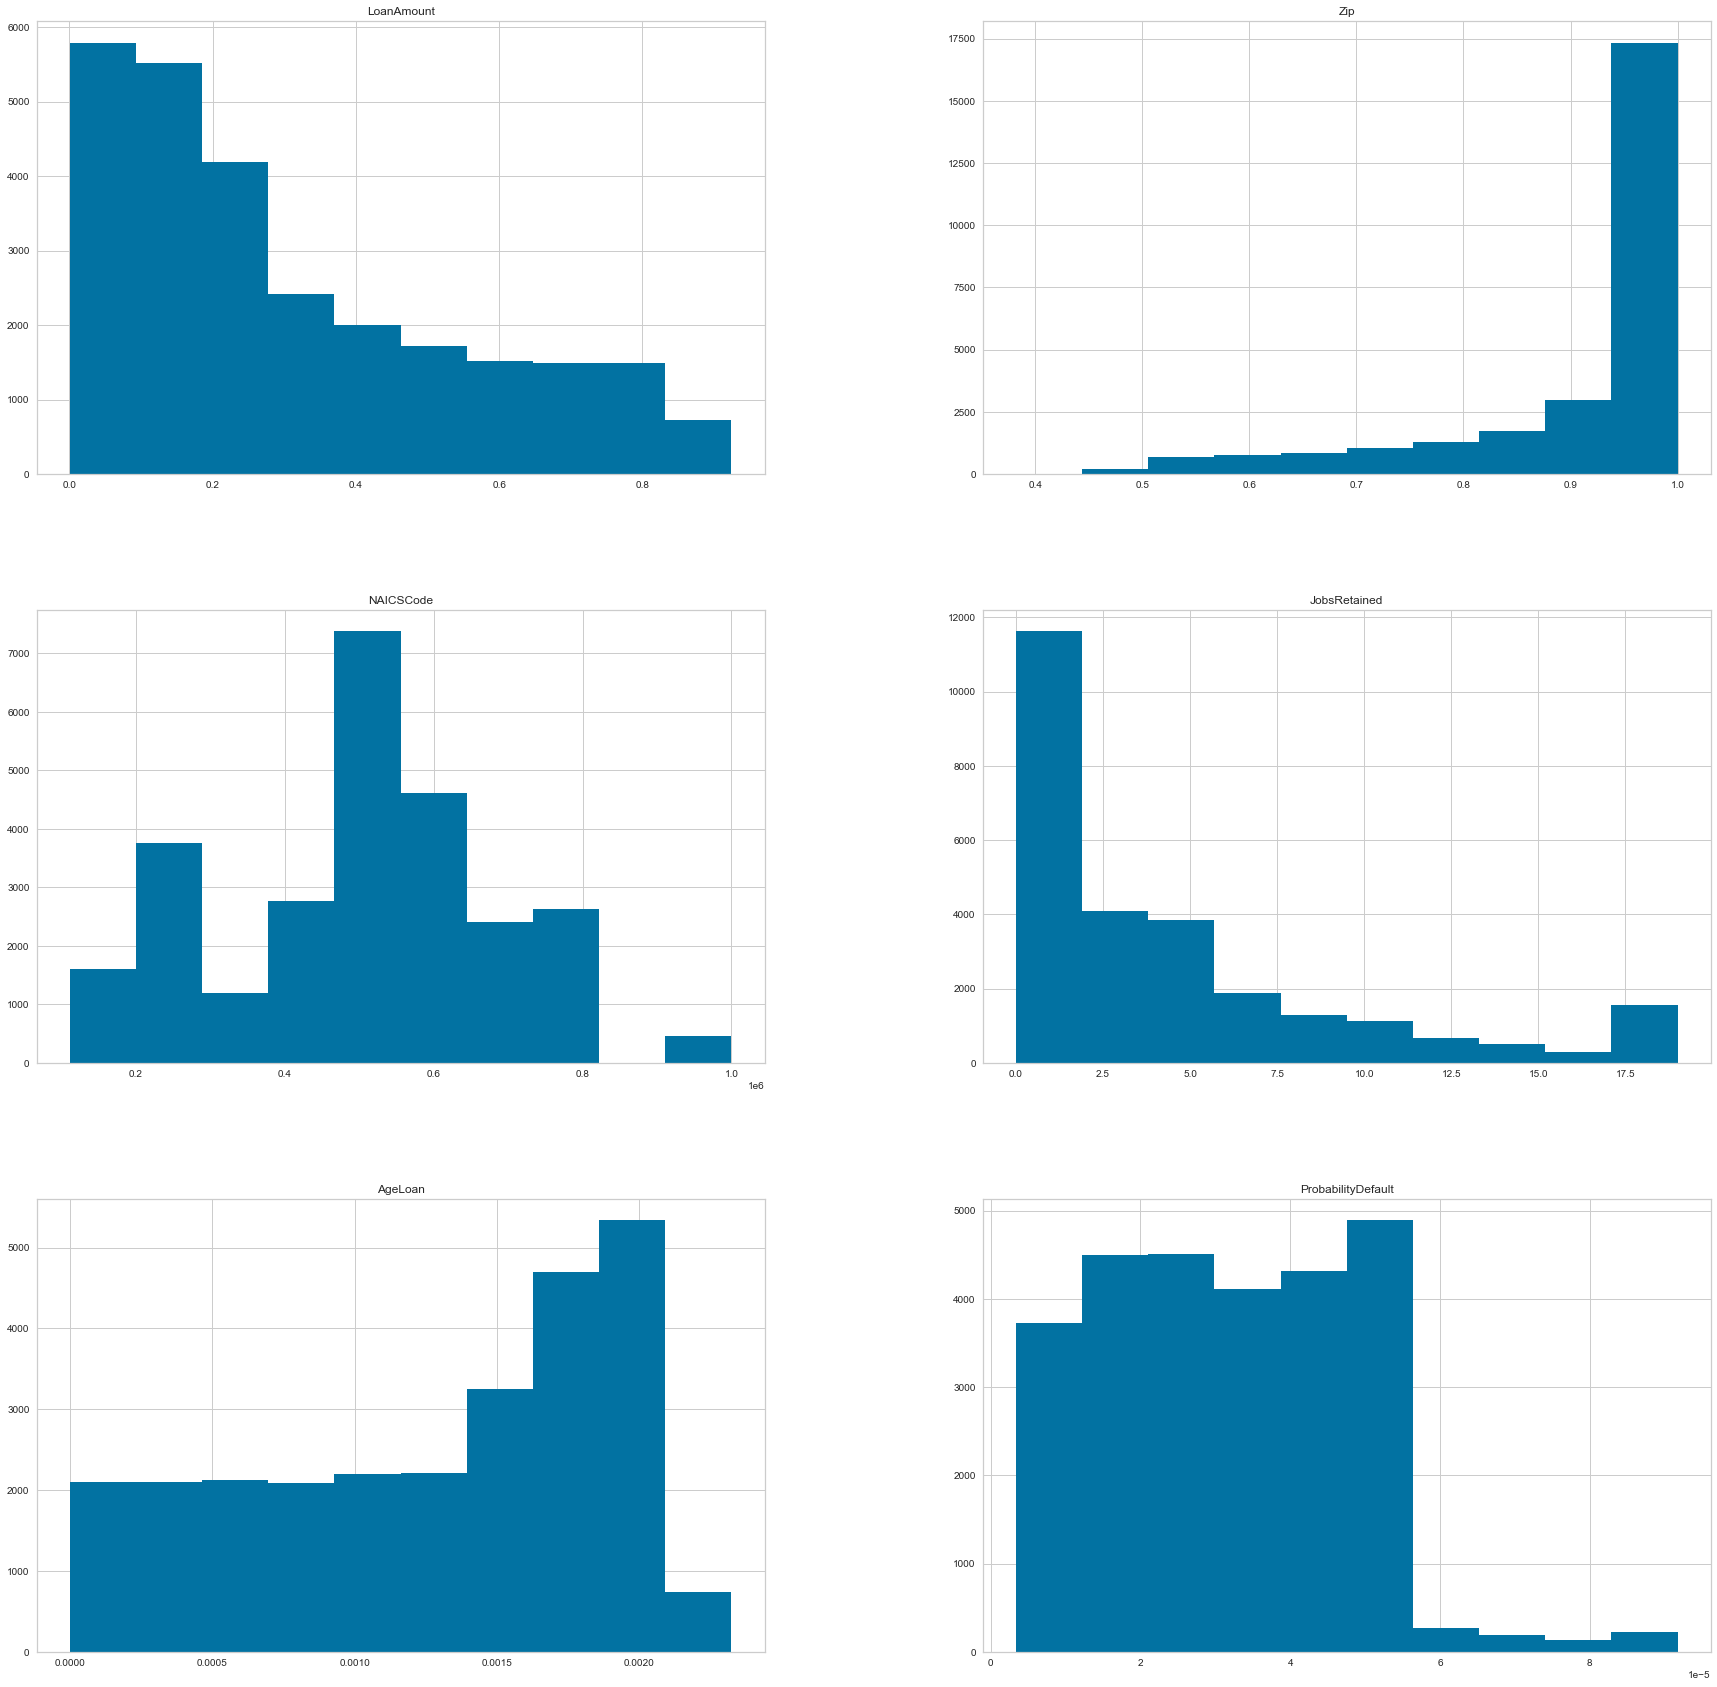

In [22]:
df_data.hist(figsize=(30,30))

# Question 2
(22 points)

Explain what a k-means model is.

- identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
------------------------------------- COPIED-------------------------------------------------------------

Estimate a k-means model with 3 clusters for the variables `LoanAmount`, `Zip`, `ProbabilityDefault` and `AgeLoan`.

In [23]:
df_data_kmeans=df_data[['LoanAmount', 'Zip', 'ProbabilityDefault', 'AgeLoan']]

In [24]:
Kmean = KMeans(n_clusters=3, random_state=25)

In [25]:
Kmean.fit(df_data_kmeans)

KMeans(n_clusters=3, random_state=25)

In [26]:
Kmean.cluster_centers_

array([[7.34661309e-01, 6.67199335e-01, 4.70286262e-05, 1.80734153e-03],
       [1.31594211e-01, 9.88379051e-01, 2.37695940e-05, 8.57214994e-04],
       [4.23287245e-01, 9.00484486e-01, 4.12235734e-05, 1.89213384e-03]])

In [27]:
y_kmeans=Kmean.predict(df_data_kmeans)

Determine with the elbow method with inertia what the right number of clusters is. Please plot the inertia and explain your choice of clusters.

In [28]:
inertia_list = []
for num_clusters in range(1, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(df_data_kmeans)
    inertia_list.append(kmeans_model.inertia_)

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

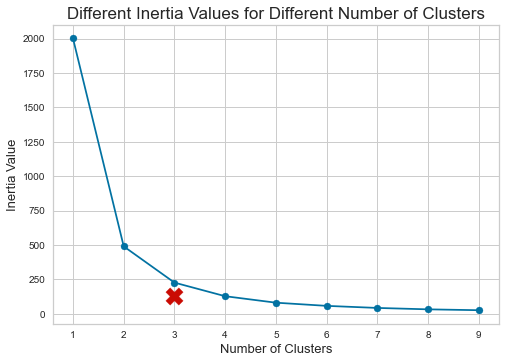

In [29]:
plt.plot(range(1,10),inertia_list)
plt.scatter(range(1,10),inertia_list)
plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia Value", size=13)
plt.title("Different Inertia Values for Different Number of Clusters", size=17)

In [30]:
Kmean.labels_

array([1, 0, 0, ..., 2, 1, 0], dtype=int32)

Do the same but this time using the silhouette score. Compare both. Would you now reconsider your choice of the previous question?

In [31]:
silhouette_s = []
for num_clusters in range(2, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(df_data_kmeans)
    silhouette_sc = silhouette_score(df_data_kmeans, kmeans_model.labels_)
    silhouette_s.append(silhouette_sc)

In [32]:
from sklearn.metrics import silhouette_samples,silhouette_score

In [33]:
silhouette_s1 = []
for i in range(2,10):
    labels= cluster.KMeans(n_clusters=i, init="k-means++", random_state=25).fit(df_data_kmeans).labels_
    silhouette_s1.append(metrics.silhouette_score(df_data_kmeans, labels,  random_state=25))

In [34]:
silhouette_s

[0.6831805651886279,
 0.6240885205895462,
 0.590421128526729,
 0.58609096282471,
 0.5696582461000601,
 0.5551650220730416,
 0.5564216493491744,
 0.5536198053776179]

Text(0.5, 1.0, 'Different Silhoulette Scores for Different Number of Clusters')

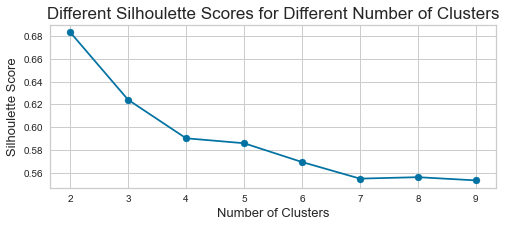

In [35]:
plt.figure(figsize=(8,3))
plt.plot(range(2,10),silhouette_s)
plt.scatter(range(2,10),silhouette_s)
# plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Silhoulette Score", size=13)
plt.title("Different Silhoulette Scores for Different Number of Clusters", size=17)

# Question 3

(22 points)

Mention one advantage and one disadvantage of using Principal Component Analysis (PCA).

- Advantages:
  1. Removes Correlated Features
  2. Improves Algorithm Performance
  3. Reduces Overfitting
  4. Improves Visualization
  
  
- Disadvantages:
  1. Independent variables become less interpretable
  2. Data standardization is must before PCA
  3. Information Loss
  
---------------------------------------COPIED------------------------------------------------------

Reduce the dataset to two dimensions with PCA and make a clear plot. Make sure to label all the important information.

In [36]:
target_name= 'ProbabilityDefault'

In [37]:
df_PCA= df_data#.drop(target_name, axis=1)

In [38]:
df_PCA.dtypes

LoanAmount            float64
City                   object
State                  object
Zip                   float64
NAICSCode             float64
BusinessType           object
RaceEthnicity          object
Gender                 object
Veteran                object
NonProfit              object
JobsRetained          float64
DateApproved           object
Lender                 object
CD                     object
AgeLoan               float64
ProbabilityDefault    float64
dtype: object

In [39]:
df_features_num = df_PCA.loc[:,df_PCA.dtypes != object]
df_features_cat = df_PCA.loc[:, df_PCA.dtypes == object]

In [40]:
df_features_num

,LoanAmount,Zip,NAICSCode,JobsRetained,AgeLoan,ProbabilityDefault
0,0.241399,0.970425,531210.0,0.0,0.001358,0.000015
1,0.690365,0.723459,722511.0,19.0,0.001985,0.000052
2,0.671117,0.741349,811121.0,7.0,0.002098,0.000021
3,0.846808,0.531897,722211.0,19.0,0.001522,0.000048
4,0.097647,0.995221,327991.0,1.0,0.000608,0.000017
...,...,...,...,...,...,...
26850,0.576126,0.817357,484210.0,10.0,0.002285,0.000049
26851,0.111974,0.993711,111998.0,4.0,0.000822,0.000030
26852,0.338781,0.940864,445120.0,13.0,0.001739,0.000040
26853,0.158657,0.987333,541320.0,0.0,0.001149,0.000026


In [41]:
df_features_cat

,City,State,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,DateApproved,Lender,CD
0,EAGLE,ID,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,2020-07-04 00:00:00,Washington Trust Bank,ID - 01
1,HAYDEN,ID,Corporation,Asian,Female Owned,Unanswered,NaN,04/15/2020,Glacier Bank,ID - 01
2,IDAHO FALLS,ID,Subchapter S Corporation,White,Male Owned,Non-Veteran,NaN,2020-10-04 00:00:00,Bank of Idaho,ID - 02
3,POST FALLS,ID,Limited Liability Company(LLC),White,Unanswered,Unanswered,NaN,04/13/2020,First Interstate Bank,ID - 01
4,RIGBY,ID,Sole Proprietorship,White,Male Owned,Non-Veteran,NaN,2020-05-05 00:00:00,Beehive FCU,ID - 02
...,...,...,...,...,...,...,...,...,...,...
26850,BOISE,ID,Corporation,Unanswered,Unanswered,Unanswered,NaN,2020-10-04 00:00:00,Mountain America FCU,ID - 02
26851,ASHTON,ID,Sole Proprietorship,Unanswered,Unanswered,Unanswered,NaN,04/28/2020,Bank of Idaho,ID - 02
26852,BUHL,ID,Subchapter S Corporation,White,Male Owned,Non-Veteran,NaN,2020-07-04 00:00:00,Farmers Bank,ID - 02
26853,SHOSHONE,ID,Corporation,Unanswered,Unanswered,Unanswered,NaN,2020-08-05 00:00:00,"Wells Fargo Bank, National Association",ID - 02


In [42]:
from sklearn.decomposition import PCA

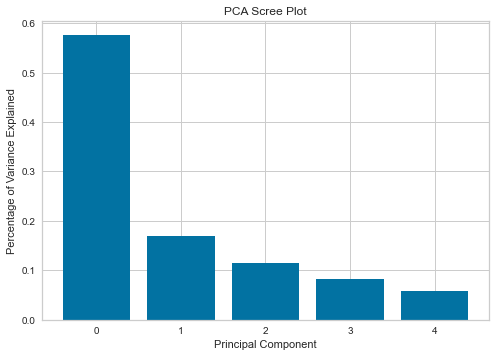

In [43]:
df_features_numstd = df_features_num / df_features_num.std()
pca = PCA(n_components=5).fit(df_features_numstd)

plt.bar(range(pca.n_components), pca.explained_variance_ratio_)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [44]:
df_features_pca = pd.DataFrame(pca.transform(df_features_numstd))
df_features_pca.index=df_features_num.index
print(df_features_num.index)

RangeIndex(start=0, stop=26855, step=1)


In [45]:
df_features_pca.columns = [f'pca.{i}' for i in df_features_pca.columns]
df_features_pca

,pca.0,pca.1,pca.2,pca.3,pca.4
0,-1.048958,-0.058116,-0.141106,0.538815,-0.849990
1,3.504524,1.573321,0.911879,-0.860441,0.143958
2,1.837972,1.567511,0.325425,1.169271,-1.199925
3,4.144477,1.709834,1.757580,0.410223,0.893126
4,-1.790233,-0.920841,0.468704,0.113017,0.167980
...,...,...,...,...,...
26850,2.472808,-0.026589,-0.209975,-0.470167,-0.443746
26851,-1.031028,-1.896680,0.532001,-0.635280,0.409343
26852,1.099872,-0.026906,0.524350,-1.428620,-0.313160
26853,-1.164369,-0.034625,-0.470907,0.156324,-0.199712


In [46]:
df_features_num1 = pd.concat([df_features_num, df_features_pca], axis=1)

In [47]:
df_features_num1

,LoanAmount,Zip,NAICSCode,JobsRetained,AgeLoan,ProbabilityDefault,pca.0,pca.1,pca.2,pca.3,pca.4
0,0.241399,0.970425,531210.0,0.0,0.001358,0.000015,-1.048958,-0.058116,-0.141106,0.538815,-0.849990
1,0.690365,0.723459,722511.0,19.0,0.001985,0.000052,3.504524,1.573321,0.911879,-0.860441,0.143958
2,0.671117,0.741349,811121.0,7.0,0.002098,0.000021,1.837972,1.567511,0.325425,1.169271,-1.199925
3,0.846808,0.531897,722211.0,19.0,0.001522,0.000048,4.144477,1.709834,1.757580,0.410223,0.893126
4,0.097647,0.995221,327991.0,1.0,0.000608,0.000017,-1.790233,-0.920841,0.468704,0.113017,0.167980
...,...,...,...,...,...,...,...,...,...,...,...
26850,0.576126,0.817357,484210.0,10.0,0.002285,0.000049,2.472808,-0.026589,-0.209975,-0.470167,-0.443746
26851,0.111974,0.993711,111998.0,4.0,0.000822,0.000030,-1.031028,-1.896680,0.532001,-0.635280,0.409343
26852,0.338781,0.940864,445120.0,13.0,0.001739,0.000040,1.099872,-0.026906,0.524350,-1.428620,-0.313160
26853,0.158657,0.987333,541320.0,0.0,0.001149,0.000026,-1.164369,-0.034625,-0.470907,0.156324,-0.199712


In [48]:
# dct_dummies = {}

# for cat, sr in df_features_cat.iteritems():
#     df_dummies = pd.get_dummies(sr.astype('category'))
#     df_dummies.columns = [f'cat.{cat}.{c}' for c in df_dummies]
#     dct_dummies[cat] = df_dummies.iloc[:,1:] # drop one to avoid multicollinearity

In [49]:
# df_features_dummies = pd.concat(dct_dummies.values(), axis=1)
# print(np.shape(df_features_dummies))

In [50]:
## How to treat probability thing? OR if its not necessary to use it in any methonds we use

This time reduce the dataset to two dimensions with t-SNE and make a clear plot.

In [51]:
tsne = TSNE(n_components=2, random_state=25, n_iter=300)
tsne_results = tsne.fit_transform(df_features_numstd)
print(tsne_results)

[[ 3.8234017   0.7204735 ]
 [-6.928365   -4.131144  ]
 [-2.5055685  -2.6283734 ]
 ...
 [-0.13754697 -2.656495  ]
 [ 9.529076    1.0398451 ]
 [-8.667791   -3.2874715 ]]


In [52]:
df_features_num1['tsne-2d-one'] = tsne_results[:,0]
df_features_num1['tsne-2d-two'] = tsne_results[:,1]

In [53]:
df_features_num1

,LoanAmount,Zip,NAICSCode,JobsRetained,AgeLoan,ProbabilityDefault,pca.0,pca.1,pca.2,pca.3,pca.4,tsne-2d-one,tsne-2d-two
0,0.241399,0.970425,531210.0,0.0,0.001358,0.000015,-1.048958,-0.058116,-0.141106,0.538815,-0.849990,3.823402,0.720474
1,0.690365,0.723459,722511.0,19.0,0.001985,0.000052,3.504524,1.573321,0.911879,-0.860441,0.143958,-6.928365,-4.131144
2,0.671117,0.741349,811121.0,7.0,0.002098,0.000021,1.837972,1.567511,0.325425,1.169271,-1.199925,-2.505569,-2.628373
3,0.846808,0.531897,722211.0,19.0,0.001522,0.000048,4.144477,1.709834,1.757580,0.410223,0.893126,-8.624166,-3.409683
4,0.097647,0.995221,327991.0,1.0,0.000608,0.000017,-1.790233,-0.920841,0.468704,0.113017,0.167980,0.064029,3.900521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26850,0.576126,0.817357,484210.0,10.0,0.002285,0.000049,2.472808,-0.026589,-0.209975,-0.470167,-0.443746,-2.015089,-0.493121
26851,0.111974,0.993711,111998.0,4.0,0.000822,0.000030,-1.031028,-1.896680,0.532001,-0.635280,0.409343,-3.345880,6.848915
26852,0.338781,0.940864,445120.0,13.0,0.001739,0.000040,1.099872,-0.026906,0.524350,-1.428620,-0.313160,-0.137547,-2.656495
26853,0.158657,0.987333,541320.0,0.0,0.001149,0.000026,-1.164369,-0.034625,-0.470907,0.156324,-0.199712,9.529076,1.039845


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

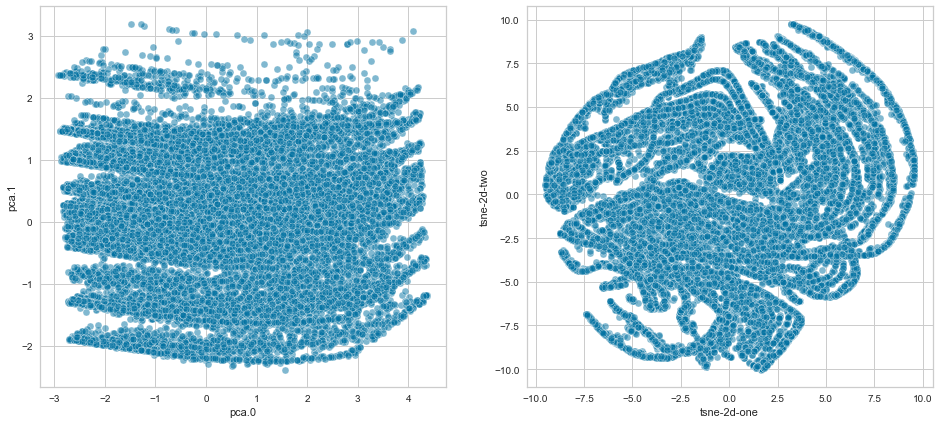

In [54]:
#Probably need target name back for hue. I included it by not dropping it in the first part of question 3
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca.0", y="pca.1",
    #hue="NAICSCode",
    data=df_features_num1,
    legend="full",
    alpha=0.5,
    ax=ax1
)

ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
     #hue="NAICSCode",
    #hue_norm=(0,255),
    data=df_features_num1,
    legend="full",
    alpha=0.5,
    ax=ax2
)

Explain whether PCA or t-SNE is better to use with this particular data set.

In [55]:
# Your answer

# Question 4

(22 points)

Add the two columns you made with PCA to the dataset. Then pick a Decision Tree model and train a good model to predict the Probability of Default (`ProbabilityDefault`). It is not necessary to tune the hyperparameters (so the default settings are fine). 

In [56]:
## Your answer
df_tree_x = df_features_num1[['pca.0','pca.1']]
df_tree_y = df_features_num1[['ProbabilityDefault']]

In [57]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(df_tree_x, df_tree_y)

Explain how well your model performs. Do you think the predictions are any good? 

In [58]:
## Your answer

# Question 5

(22 points)

This question turns on how to tune hyperparameters. Please compute what you consider the best choice for "splitter", "max_depth", and "min_samples_leaf" (jointly).

In [59]:
## Your answer

Does your hyperparameter tuning does lead to overfitting? Provide arguments.

In [60]:
## Your answer

Explain whether you consider the hyperparameter tuning useful (given amongst others the compute time, precision, other considerations, etc.).

In [61]:
## Your answer

---